## 3.5 非線形応答を計算してみる

In [1]:
using Distributed
addprocs(30)

30-element Vector{Int64}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
  ⋮
 20
 21
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31

In [2]:
@everywhere struct Parm
    m::Float64
    lamda::Float64
    #=
    t::Float64
    lamda_u::Float64
    lamda_d::Float64
    Pr::Float64
    =#
    hx::Float64
    hy::Float64
    hz::Float64
    mu::Float64
    eta::Float64
    T::Float64
    K_MAX::Float64
    K_SIZE::Int
    W_MAX::Float64
    W_SIZE::Int
end

In [3]:

@everywhere a1 = [1.0, 0.0]
@everywhere a2 = [-0.5, sqrt(3.0)/2.0]

In [3]:
@everywhere using LinearAlgebra
@everywhere sigma = [[1.0 0.0; 0.0 1.0], [0.0 1.0; 1.0 0.0], [0.0 -1.0im; 1.0im 0.0], [1.0 0.0; 0.0 -1.0]]

In [5]:


@everywhere mutable struct Hamiltonian
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vyx::Array{ComplexF64,2}
    Vyy::Array{ComplexF64,2}
    #後々非エルミートに拡張できるようにComplexF64にしているが、別にFloat64でも良いはず
    E::Array{ComplexF64,1}
end

#Photo-voltaicまでしか計算しないと思ってGRp,GAmまでしか用意してません。（SHGを計算したいならGRpp,GAmmを用意する必要あり）
@everywhere mutable struct Green
    GR::Array{ComplexF64,2}
    GA::Array{ComplexF64,2}
    dGR::Array{ComplexF64,2}
    ddGR::Array{ComplexF64,2}
    GRmA::Array{ComplexF64,2}
    GRp::Array{ComplexF64,2}
    GAp::Array{ComplexF64,2}
    GRm::Array{ComplexF64,2}
    GAm::Array{ComplexF64,2}
end

In [6]:
@everywhere function HandV_topo(k::NTuple{2, Float64},p::Parm)

    eps::Float64 = (k[1]*k[1] + k[2]*k[2])/(2.0*p.m) + p.mu
    g_x::Float64 = -p.lamda*k[2] + p.hx
    g_y::Float64 = p.lamda*k[1] + p.hy
    g_z::Float64 = p.hz
    gg = [eps, g_x, g_y, g_z]
    H::Array{ComplexF64,2} =  gg' * sigma

    eps_vx::Float64 = k[1]/p.m
    gx_vx::Float64 = 0.0
    gy_vx::Float64 = p.lamda
    gz_vx::Float64 = 0.0
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vx::Array{ComplexF64,2} = gg_x' * sigma


    eps_vy::Float64 = k[2]/p.m
    gx_vy::Float64 = -p.lamda
    gy_vy::Float64 = 0.0
    gz_vy::Float64 = 0.0
    gg_y = [eps_vy, gx_vy, gy_vy, gz_vy]
    Vy::Array{ComplexF64,2} = gg_y' * sigma

    Vxx::Array{ComplexF64,2} = sigma[1]./p.m
    
    Vyy::Array{ComplexF64,2} = sigma[1]./p.m

    Vyx::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vxx, Vyx, Vyy, E 
end

@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    ddGR::Array{ComplexF64,2} = 2.0 * GR * GR * GR
    GRp0::Array{ComplexF64,2} = -Ham.Hk + (w+p.W_in)*Matrix{Complex{Float64}}(I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GRp = inv(GRp0)
    GAp = GRp'

    GRm0::Array{ComplexF64,2} = -Ham.Hk + (w-p.W_in)*Matrix{Complex{Float64}}(I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)
    GRm = inv(GRm0)
    GAm = GRm'
    return GR, GA, dGR, ddGR, GRmA, GRp, GAp, GRm, GAm
end

In [7]:
@everywhere f(e::Float64,T::Float64) = 1.0/(1.0+exp(e/T))
@everywhere df(e::Float64,T::Float64) = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T

@everywhere function f(e::ComplexF64,T::Float64)
    FD::ComplexF64 = 1.0/(1.0+exp(e/T))
    return FD
end
@everywhere function df(e::ComplexF64,T::Float64)
    dFD::ComplexF64 = -1.0/(1.0+exp(e/T))/(1.0+exp(-e/T))/T
    return dFD
end

@everywhere function Green_NLR(p::Parm, H::Hamiltonian)
    XXX::Float64 = 0.0
    XYY::Float64 = 0.0

    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Gk(w,p,H)...)
        XXX += 4.0p.W_MAX*imag(tr(H.Vx*G.dGR*(H.Vx*G.GR*H.Vx + H.Vxx)*G.GRmA)*df(w,p.T)/p.W_SIZE)/(2.0pi)
        XYY += 4.0p.W_MAX*imag(tr(H.Vx*G.dGR*(H.Vy*G.GR*H.Vy + H.Vyy)*G.GRmA)*df(w,p.T)/p.W_SIZE)/(2.0pi)
    end
    return XXX, XYY
end

In [7]:
#Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE  
p1 = Parm(3.0, 1.0, 0.0, 0.3, 0.0, 0.0, 0.01, 0.01, 1.0, 400, 0.5, 2000)
#そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、
#[1:end-1]とする事で、collectで集める部分を指定している。「end」は配列の最後の要素を指す
#k_test = (0.0, 0.5)
#Ham_test = Hamiltonian(HandV_topo(k_test,p1)...)

k = collect(Iterators.product((-p1.K_MAX:2*p1.K_MAX/p1.K_SIZE:p1.K_MAX)[1:end-1], (-p1.K_MAX:2*p1.K_MAX/p1.K_SIZE:p1.K_MAX)[1:end-1]))

XXX, XYY = @distributed (+) for i in 1:length(k)
    Hamk = Hamiltonian(HandV_topo(k[i],p1)...)
    NR, NLH = Green_NLR(p1,Hamk)
    [NR/(p1.K_SIZE^2), NLH/(p1.K_SIZE^2)]
end

println("Drude = $(XXX), QHE = $(XYY)")


Drude = -78.5005811400631, QHE = -72.33032014479224


In [8]:
mu0 = collect(-0.2:0.02:0.2)
XXX_mu = zeros(Float64,length(mu0))
XYY_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    p = Parm(3.0, 1.0, 0.0, 0.3, 0.0, mu0[j], 0.01, 0.01, 1.0, 400, 0.5, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    XXX_mu[j], XYY_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        NR, NLH = Green_NLR(p,Hamk)
        [NR/(p.K_SIZE^2), NLH/(p.K_SIZE^2)]
    end
end

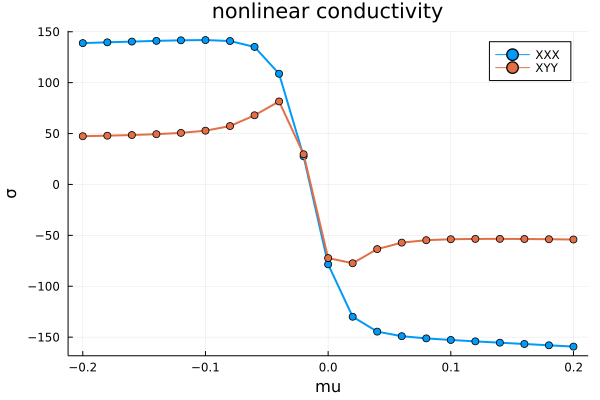

In [10]:
using Plots
plot(mu0, XXX_mu, label="XXX",xlabel="mu",ylabel="σ",title="nonlinear conductivity", width=2.0, marker =:circle)
plot!(mu0, XYY_mu, label="XYY", width=2.0, marker =:circle)

In [8]:
@everywhere function HV_BI(H::Hamiltonian)

    H.E, BI::Array{ComplexF64,2} = eigen(H.Hk)
    Vx_BI::Array{ComplexF64,2} = BI' * H.Vx * BI
    Vy_BI::Array{ComplexF64,2} = BI' * H.Vy * BI
    Vxx_BI::Array{ComplexF64,2} = BI' * H.Vxx * BI
    Vyx_BI::Array{ComplexF64,2} = BI' * H.Vyx * BI
    Vyy_BI::Array{ComplexF64,2} = BI' * H.Vyy * BI

    H.Vx = Vx_BI
    H.Vy = Vy_BI
    H.Vxx = Vxx_BI
    H.Vyx = Vyx_BI
    H.Vyy = Vyy_BI
end



@everywhere function Green_BI(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse

    GR::Array{ComplexF64,2} = [1.0/(w-Ham.E[1]+1.0im*p.eta) 0; 0 1.0/(w-Ham.E[2]+1.0im*p.eta)]
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    ddGR::Array{ComplexF64,2} = 2.0 * GR * GR * GR
    GRp = zeros(ComplexF64,2,2)
    GAm = zeros(ComplexF64,2,2)
    return GR, GA, dGR, ddGR, GRmA, GRp, GAm
end

In [16]:
@everywhere using Einsum

@everywhere function Green_XXX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vx[i,i]*H.Vx[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_XYY_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vy[i,i]*H.Vy[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vyy[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vy[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vy[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end

    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

In [27]:
mu0 = collect(-0.4:0.02:0.4)
Drude_mu = zeros(Float64,length(mu0))
BCD_mu = zeros(Float64,length(mu0))
sQMD_mu = zeros(Float64,length(mu0))
dQMD_mu = zeros(Float64,length(mu0))
Inter_mu = zeros(Float64,length(mu0))
dInter_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(5.0, 1.0, 0.0, 0.3, 0.0, mu0[j], 0.05, 0.05, 1.0, 400, 0.5, 2000)
    if j == 1
        println(p)
    end
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    Drude_mu[j], BCD_mu[j], sQMD_mu[j], dQMD_mu[j], Inter_mu[j], dInter_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        Dr, Bc, sQ, dQ, In, dIn = Green_XYY_BI(p,Hamk)
        [Dr/(p.K_SIZE^2), Bc/(p.K_SIZE^2), sQ/(p.K_SIZE^2), dQ/(p.K_SIZE^2), In/(p.K_SIZE^2), dIn/(p.K_SIZE^2)]
    end
end

Parm(5.0, 1.0, 0.0, 0.3, 0.0, -0.4, 0.05, 0.05, 1.0, 400, 0.5, 2000)


In [20]:
Drude2_mu = zeros(Float64,length(mu0))
BCD2_mu = zeros(Float64,length(mu0))
sQMD2_mu = zeros(Float64,length(mu0))
dQMD2_mu = zeros(Float64,length(mu0))
Inter2_mu = zeros(Float64,length(mu0))
dInter2_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(5.0, 1.0, 0.3, 0.0, 0.0, mu0[j], 0.06, 0.05, 1.0, 400, 0.5, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    Drude2_mu[j], BCD2_mu[j], sQMD2_mu[j], dQMD2_mu[j], Inter2_mu[j], dInter2_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        Dr, Bc, sQ, dQ, In, dIn = Green_XYY_BI(p,Hamk)
        [Dr/(p.K_SIZE^2), Bc/(p.K_SIZE^2), sQ/(p.K_SIZE^2), dQ/(p.K_SIZE^2), In/(p.K_SIZE^2), dIn/(p.K_SIZE^2)]
    end
end

$\mu$依存性のプロット

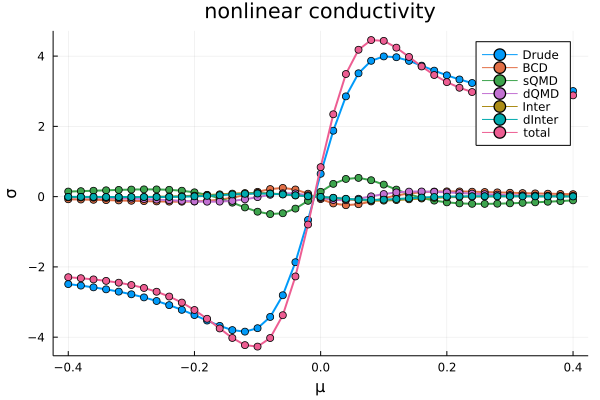

In [28]:
using Plots
plot(mu0, Drude_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BCD_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMD_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, Inter_mu, label="Inter", width=2.0, marker=:circle)
plot!(mu0, dInter_mu, label="dInter", width=2.0, marker=:circle)
plot!(mu0, Drude_mu+BCD_mu+sQMD_mu+sQMD_mu+Inter_mu+dInter_mu, label="total", width=2.0, marker=:circle)

$\eta$依存性も確認してみる

In [64]:
Drude2_mu = zeros(Float64,length(mu0))
BCD2_mu = zeros(Float64,length(mu0))
sQMD3_mu = zeros(Float64,length(mu0))
dQMD2_mu = zeros(Float64,length(mu0))
Inter2_mu = zeros(Float64,length(mu0))
dInter2_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(5.0, 1.0, 0.3, 0.0, 0.0, mu0[j], 0.06, 0.05, 1.0, 400, 0.5, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    Drude2_mu[j], BCD2_mu[j], sQMD3_mu[j], dQMD2_mu[j], Inter2_mu[j], dInter2_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        Dr, Bc, sQ, dQ, In, dIn = Green_XYY_BI(p,Hamk)
        [Dr/(p.K_SIZE^2), Bc/(p.K_SIZE^2), sQ/(p.K_SIZE^2), dQ/(p.K_SIZE^2), In/(p.K_SIZE^2), dIn/(p.K_SIZE^2)]
    end
end

In [66]:
Drude2_mu = zeros(Float64,length(mu0))
BCD2_mu = zeros(Float64,length(mu0))
sQMD4_mu = zeros(Float64,length(mu0))
dQMD2_mu = zeros(Float64,length(mu0))
Inter2_mu = zeros(Float64,length(mu0))
dInter2_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(5.0, 1.0, 0.3, 0.0, 0.0, mu0[j], 0.04, 0.05, 1.0, 400, 0.5, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    Drude2_mu[j], BCD2_mu[j], sQMD4_mu[j], dQMD2_mu[j], Inter2_mu[j], dInter2_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        Dr, Bc, sQ, dQ, In, dIn = Green_XYY_BI(p,Hamk)
        [Dr/(p.K_SIZE^2), Bc/(p.K_SIZE^2), sQ/(p.K_SIZE^2), dQ/(p.K_SIZE^2), In/(p.K_SIZE^2), dIn/(p.K_SIZE^2)]
    end
end

ピークのところで$\eta$を大きくすると減っていくので、ピークのところはDrude項に対する補正の部分がdominantで、それ以外の所は$\eta$依存性が小さいので、有効的にQMD項となっている事が分かる。

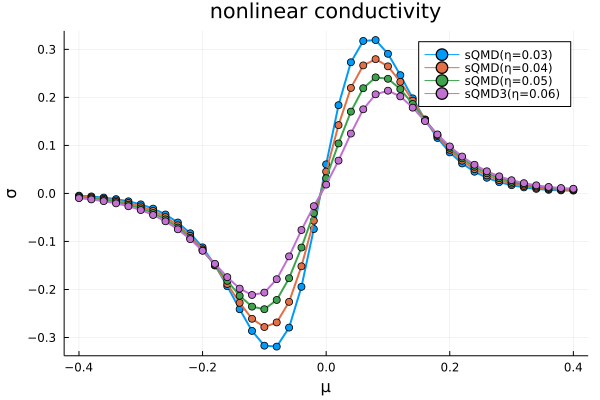

In [70]:
using Plots
plot(mu0, sQMD2_mu, label="sQMD(η=0.03)",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
#plot!(mu0, BCD_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMD4_mu, label="sQMD(η=0.04)", width=2.0, marker=:circle)
plot!(mu0, sQMD_mu, label="sQMD(η=0.05)", width=2.0, marker=:circle)
plot!(mu0, sQMD3_mu, label="sQMD3(η=0.06)", width=2.0, marker=:circle)
#plot!(mu0, dQMD_mu, label="dQMD", width=2.0, marker=:circle)
#plot!(mu0, Inter_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter_mu, label="dInter", width=2.0, marker=:circle)

In [71]:
DrudeY_mu = zeros(Float64,length(mu0))
BCDY_mu = zeros(Float64,length(mu0))
sQMDY_mu = zeros(Float64,length(mu0))
dQMDY_mu = zeros(Float64,length(mu0))
InterY_mu = zeros(Float64,length(mu0))
dInterY_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(5.0, 1.0, 0.0, 0.3, 0.0, mu0[j], 0.05, 0.05, 1.0, 400, 0.5, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    DrudeY_mu[j], BCDY_mu[j], sQMDY_mu[j], dQMDY_mu[j], InterY_mu[j], dInterY_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        Dr, Bc, sQ, dQ, In, dIn = Green_XXX_BI(p,Hamk)
        [Dr/(p.K_SIZE^2), Bc/(p.K_SIZE^2), sQ/(p.K_SIZE^2), dQ/(p.K_SIZE^2), In/(p.K_SIZE^2), dIn/(p.K_SIZE^2)]
    end
end

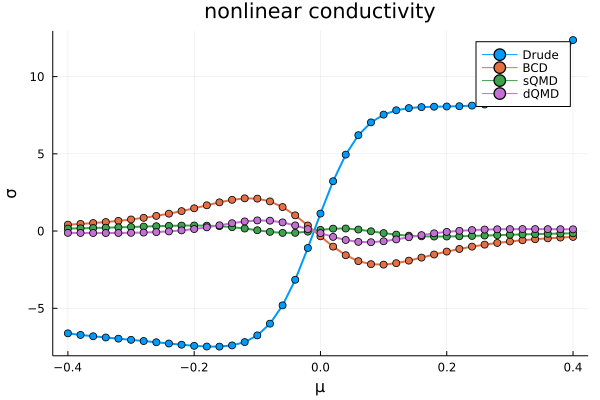

In [76]:
plot(mu0, DrudeY_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BCDY_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMDY_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMDY_mu, label="dQMD", width=2.0, marker=:circle)
#plot!(mu0, InterY_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInterY_mu, label="dInter", width=2.0, marker=:circle)

In [9]:
@everywhere function Green_XX_BI(p::Parm, H::Hamiltonian)
    
    Drude::Float64 = 0.0
    BC::Float64 = 0.0
    dQM::Float64 = 0.0
    
    HV_BI(H)

    for i = 1:2
        Drude += -real(2.0*H.Vx[i,i]*H.Vx[i,i])*real(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta)

        BC += -2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(f(H.E[i]+1.0im*p.eta, p.T))
        dQM += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(f(H.E[i]+1.0im*p.eta, p.T))
    end
    return Drude, BC, dQM
end

In [77]:
DrudeL_mu = zeros(Float64,length(mu0))
BC_mu = zeros(Float64,length(mu0))
dQM_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(5.0, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.1, 0.1, 1.0, 400, 0.5, 2000)
    #そのままcollectすると要素が「(K_SIZE+1)*(K_SIZE+1)」になってしまうので(edgeでdouble countしている)、[1:end-1]とする事で、collectで集める部分を指定している。
    k = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))

    DrudeL_mu[j], BC_mu[j], dQM_mu[j] = @distributed (+) for i in 1:length(k)
        Hamk = Hamiltonian(HandV_topo(k[i],p)...)
        Dr, Bc, dQ = Green_XX_BI(p,Hamk)
        [Dr/(p.K_SIZE^2), Bc/(p.K_SIZE^2), dQ/(p.K_SIZE^2)]
    end
end

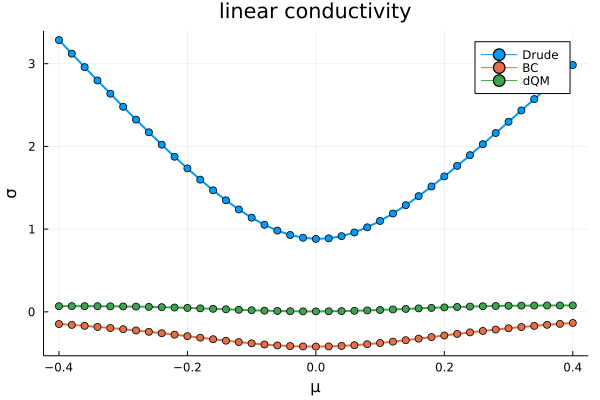

In [78]:
plot(mu0, DrudeL_mu, label="Drude",xlabel="μ",ylabel="σ",title="linear conductivity", width=2.0, marker=:circle)
plot!(mu0, BC_mu, label="BC", width=2.0, marker=:circle)
plot!(mu0, dQM_mu, label="dQM", width=2.0, marker=:circle)

## Weyl Hamiltonianでの計算

In [10]:
@everywhere mutable struct Hamiltonian_3D
    Hk::Array{ComplexF64,2}
    Vx::Array{ComplexF64,2}
    Vy::Array{ComplexF64,2}
    Vz::Array{ComplexF64,2}
    Vxx::Array{ComplexF64,2}
    Vyx::Array{ComplexF64,2}
    Vyy::Array{ComplexF64,2}
    Vxz::Array{ComplexF64,2}
    Vyz::Array{ComplexF64,2}
    Vzz::Array{ComplexF64,2}
    #後々非エルミートに拡張できるようにComplexF64にしているが、別にFloat64でも良いはず
    E::Array{ComplexF64,1}
end

@everywhere function HandV_weyl(k::NTuple{3, Float64},p::Parm)

    #eps::Float64 = (k[1]*k[1] + k[2]*k[2] + k[3]*k[3])/(2.0*p.m) + p.mu
    #eps::Float64 = (k[1]*k[1])/(2.0*p.m) + p.mu
    eps::Float64 = p.m*k[1] + p.mu
    g_x::Float64 = p.lamda*k[1] + p.hx
    g_y::Float64 = p.lamda*k[2] + p.hy
    g_z::Float64 = p.lamda*k[3] + p.hz
    gg = [eps, g_x, g_y, g_z]
    H::Array{ComplexF64,2} =  gg' * sigma

    eps_vx::Float64 = p.m
    gx_vx::Float64 = p.lamda
    gy_vx::Float64 = 0.0
    gz_vx::Float64 = 0.0
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vx::Array{ComplexF64,2} = gg_x' * sigma


    eps_vy::Float64 = 0.0
    gx_vy::Float64 = 0.0
    gy_vy::Float64 = p.lamda
    gz_vy::Float64 = 0.0
    gg_y = [eps_vy, gx_vy, gy_vy, gz_vy]
    Vy::Array{ComplexF64,2} = gg_y' * sigma

    eps_vz::Float64 = 0.0
    gx_vz::Float64 = 0.0
    gy_vz::Float64 = 0.0
    gz_vz::Float64 = p.lamda
    gg_z = [eps_vz, gx_vz, gy_vz, gz_vz]
    Vz::Array{ComplexF64,2} = gg_z' * sigma

    Vxx::Array{ComplexF64,2} = zeros(2,2)
    #sigma[1]./p.m
    
    Vyy::Array{ComplexF64,2} = zeros(2,2)
    #sigma[1]./p.m

    Vyx::Array{ComplexF64,2} = zeros(2,2)

    Vxz::Array{ComplexF64,2} = zeros(2,2)
    Vyz::Array{ComplexF64,2} = zeros(2,2)

    Vzz::Array{ComplexF64,2} = zeros(2,2)
    #[0.0 0.0; 0.0 0.0]

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vz, Vxx, Vyx, Vyy, Vxz, Vyz, Vzz, E
end

@everywhere function HV_BI_3D(H::Hamiltonian_3D)

    H.E, BI::Array{ComplexF64,2} = eigen(H.Hk)
    Vx_BI::Array{ComplexF64,2} = BI' * H.Vx * BI
    Vy_BI::Array{ComplexF64,2} = BI' * H.Vy * BI
    Vz_BI::Array{ComplexF64,2} = BI' * H.Vz * BI
    Vxx_BI::Array{ComplexF64,2} = BI' * H.Vxx * BI
    Vyx_BI::Array{ComplexF64,2} = BI' * H.Vyx * BI
    Vyy_BI::Array{ComplexF64,2} = BI' * H.Vyy * BI
    Vxz_BI::Array{ComplexF64,2} = BI' * H.Vxz * BI
    Vyz_BI::Array{ComplexF64,2} = BI' * H.Vyz * BI
    Vzz_BI::Array{ComplexF64,2} = BI' * H.Vzz * BI

    H.Vx = Vx_BI
    H.Vy = Vy_BI
    H.Vz = Vz_BI
    H.Vxx = Vxx_BI
    H.Vyx = Vyx_BI
    H.Vyy = Vyy_BI
    H.Vxz = Vxz_BI
    H.Vyz = Vyz_BI
    H.Vzz = Vzz_BI
end

In [11]:
@everywhere function SC_PV_NLH(p::Parm, H::Hamiltonian_3D)
    ZXY_YX::Float64 = 0.0
    XYZ_ZY::Float64 = 0.0
    HV_BI_3D(H)
    for i = 1:2
        ZXY_YX += imag((H.Vz[i,3-i]*H.Vx[3-i,i]*H.Vy[i,i] + H.Vz[i,3-i]*H.Vy[3-i,i]*H.Vx[i,i])/((H.E[i]-H.E[3-i])^2+p.eta^2))*real(df(H.E[i],p.T)) 
        XYZ_ZY += imag((H.Vx[i,3-i]*H.Vy[3-i,i]*H.Vz[i,i] + H.Vx[i,3-i]*H.Vz[3-i,i]*H.Vy[i,i])/((H.E[i]-H.E[3-i])^2+p.eta^2))*real(df(H.E[i],p.T))
    end
    return ZXY_YX, XYZ_ZY
end

In [37]:
p0 = Parm(0.3, 1.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 1.0, 400, 0.5, 2000)
k00 = (0.0,0.0,-0.5)
H_test = Hamiltonian_3D(HandV_weyl(k00,p0)...)
#HV_BI_3D(H_test)
zxy, xyz = SC_PV_NLH(p0, H_test)

(0.0, -0.1316446865503001)

K_SIZE=400で40分くらいかかる

In [13]:
mu0 = collect(-0.1:0.02:0.1)
ZXY_mu = zeros(Float64,length(mu0))
XYZ_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.005, 1.0, 250, 0.5, 1000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        ZXY1::Float64 = 0.0
        XYZ1::Float64 = 0.0
        ZXY1, XYZ1 = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            ZXY0, XYZ0 = SC_PV_NLH(p,Hamk)
            [ZXY0/(p.K_SIZE^3), XYZ0/(p.K_SIZE^3)]
        end
        ZXY_mu[j] += ZXY1 
        XYZ_mu[j] += XYZ1
        #println(XYZ_mu[j])
    end
    println(XYZ_mu[j])
end

-1.3191385071464476e-10
-7.202249573800769e-9
-3.932247585115656e-7
-2.1455210928448604e-5
-0.0011304131976506394
-0.016000000000000025
-0.0011304131976506303
-2.1455210928443474e-5
-3.9322475850232264e-7
-7.202249567807277e-9
-1.319138114192773e-10


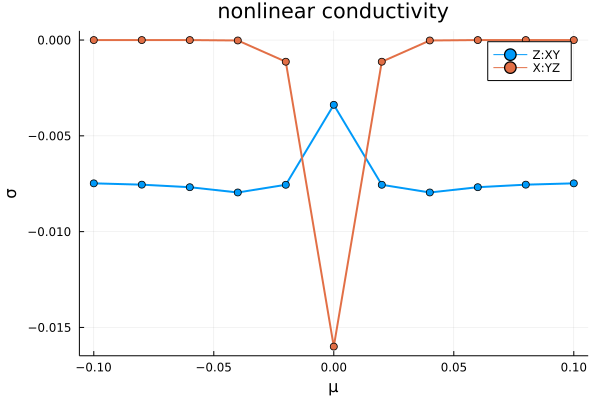

In [14]:
using Plots
plot(mu0, ZXY_mu, label="Z:XY",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, XYZ_mu, label="X:YZ", width=2.0, marker=:circle)
#plot!(mu0, sQMDW_mu, label="sQMD", width=2.0, marker=:circle)
#plot!(mu0, dQMDW_mu, label="dQMD", width=2.0, marker=:circle)
#plot!(mu0, InterW_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInterW_mu, label="dInter", width=2.0, marker=:circle)

## type-II Weyl

In [47]:
ZXY2_mu = zeros(Float64,length(mu0))
XYZ2_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.5, 0.3, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.005, 1.0, 400, 0.5, 2000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        ZXY1::Float64 = 0.0
        XYZ1::Float64 = 0.0
        ZXY1, XYZ1 = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            ZXY0, XYZ0 = SC_PV_NLH(p,Hamk)
            [ZXY0/(p.K_SIZE^3), XYZ0/(p.K_SIZE^3)]
        end
        ZXY2_mu[j] += ZXY1 
        XYZ2_mu[j] += XYZ1
        #println(XYZ_mu[j])
    end
    #println(XYZ2_mu[j])
end

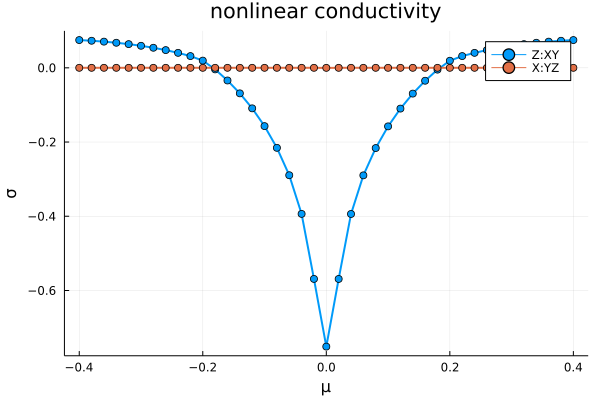

In [48]:
plot(mu0, ZXY2_mu, label="Z:XY",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, XYZ2_mu, label="X:YZ", width=2.0, marker=:circle)

In [12]:
@everywhere function Green_XYZ_BI(p::Parm, H::Hamiltonian_3D)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI_3D(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vy[i,i]*H.Vz[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vy[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vyz[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vz[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vy[i,3-i]*H.Vz[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vz[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vy[3-i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vy[3-i,3-i]*H.Vz[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end
    #=
    for w = collect(Float64,-p.W_MAX:2*p.W_MAX/p.W_SIZE:p.W_MAX)
        G = Green(Green_BI(w,p,H)...)
    end=#
    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_ZXY_BI(p::Parm, H::Hamiltonian_3D)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI_3D(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vz[i,i]*(H.Vx[i,i]*H.Vy[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vyx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vz[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vz[i,i]*H.Vx[i,3-i]*H.Vy[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vz[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vy[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vz[i,3-i]*H.Vx[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vz[i,3-i]*H.Vx[3-i,3-i]*H.Vy[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end

    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_XXX_BI(p::Parm, H::Hamiltonian_3D)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI_3D(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vx[i,i]*H.Vx[i,i]*imag(df(H.E[i]+1.0im*p.eta, p.T))/(2.0p.eta) + H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end

    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

@everywhere function Green_XXX_BI2(p::Parm, H::Hamiltonian_3D)
    
    Drude::Float64 = 0.0
    BCD::Float64 = 0.0
    sQMD::Float64 = 0.0
    dQMD::Float64 = 0.0
    Inter::Float64 = 0.0
    dInter::Float64 = 0.0

    HV_BI_3D(H)

    for i = 1:2
        Drude += 2.0*real(2.0*H.Vx[i,i]*(H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta)*real(df(H.E[i]+1.0im*p.eta, p.T)) + H.Vxx[i,i]*real(df(H.E[i]+1.0im*p.eta, p.T))))/((2.0p.eta)^2)

        BCD += -2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))real(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        sQMD += -2.0*imag(2.0*H.Vx[i,i]*H.Vx[i,3-i]*H.Vx[3-i,i]/(H.E[i]-H.E[3-i]+2.0im*p.eta))*imag(df(H.E[i]+1.0im*p.eta, p.T))/((2.0p.eta)^2)
        dQMD += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^2))imag(H.Vx[i,i]*df(H.E[i]+1.0im*p.eta, p.T))/p.eta
        Inter += -2.0*real(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*real(df(H.E[i]+1.0im*p.eta, p.T))
        dInter += 2.0*imag(H.Vx[i,3-i]*H.Vx[3-i,3-i]*H.Vx[3-i,i]/((H.E[i]-H.E[3-i]+2.0im*p.eta)^3))*imag(df(H.E[i]+1.0im*p.eta, p.T))
    end

    return Drude, BCD, sQMD, dQMD, Inter, dInter
end

In [25]:
mu0 = collect(-0.4:0.02:0.4)
total_XXX_mu = zeros(Float64,length(mu0))
Drude_XXX_mu = zeros(Float64,length(mu0))
BCD_XXX_mu = zeros(Float64,length(mu0))
sQMD_XXX_mu = zeros(Float64,length(mu0))
dQMD_XXX_mu = zeros(Float64,length(mu0))
Inter_XXX_mu = zeros(Float64,length(mu0))
dInter_XXX_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.005, 1.0, 250, 0.5, 1000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI2(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XXX_mu[j] += Drude
        BCD_XXX_mu[j] += BCD
        sQMD_XXX_mu[j] += sQMD
        dQMD_XXX_mu[j] += dQMD
        Inter_XXX_mu[j] += Inter
        dInter_XXX_mu[j] += dInter
    end
    total_XXX_mu[j] = Drude_XXX_mu[j] + BCD_XXX_mu[j] + sQMD_XXX_mu[j] + dQMD_XXX_mu[j] + Inter_XXX_mu[j] + dInter_XXX_mu[j]
end

In [26]:
using DataFrames
using CSV
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成
save_data_xxx = DataFrame(mu=mu0,total=total_XXX_mu,BCD=BCD_XXX_mu, sQMD=sQMD_XXX_mu, dQMD=dQMD_XXX_mu, Inter=Inter_XXX_mu, dInter=dInter_XXX_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./mu_dep_NLH_DC_type1_XXX_T0005_K250.csv", save_data_xxx)

"./mu_dep_NLH_DC_type1_XXX_T0005_K250.csv"

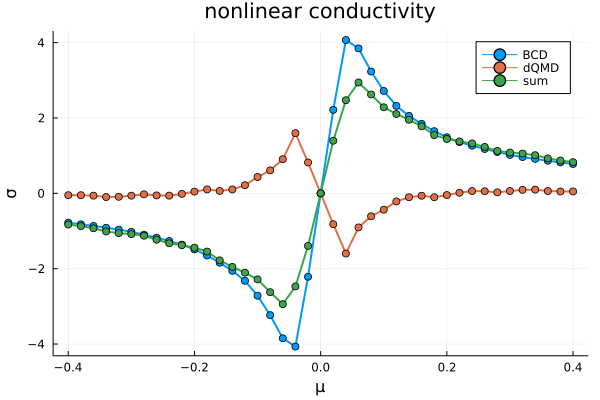

In [35]:
#using Plots
#plot(mu0, Drude_XXX_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot(mu0, BCD_XXX_mu, label="BCD",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
#plot(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX_mu+BCD_XXX_mu, label="sum", width=2.0, marker=:circle)
#plot!(mu0, Inter_XXX_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter_XXX_mu, label="dInter", width=2.0, marker=:circle)
#plot!(mu0, total_XXX_mu, label="total", width=2.0, marker=:circle)

In [36]:
total_XXX2_mu = zeros(Float64,length(mu0))
Drude_XXX2_mu = zeros(Float64,length(mu0))
BCD_XXX2_mu = zeros(Float64,length(mu0))
sQMD_XXX2_mu = zeros(Float64,length(mu0))
dQMD_XXX2_mu = zeros(Float64,length(mu0))
Inter_XXX2_mu = zeros(Float64,length(mu0))
dInter_XXX2_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.03, 0.005, 1.0, 250, 0.5, 1000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI2(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XXX2_mu[j] += Drude
        BCD_XXX2_mu[j] += BCD
        sQMD_XXX2_mu[j] += sQMD
        dQMD_XXX2_mu[j] += dQMD
        Inter_XXX2_mu[j] += Inter
        dInter_XXX2_mu[j] += dInter
    end
    total_XXX2_mu[j] = Drude_XXX2_mu[j] + BCD_XXX2_mu[j] + sQMD_XXX2_mu[j] + dQMD_XXX2_mu[j] + Inter_XXX2_mu[j] + dInter_XXX2_mu[j]
end

In [37]:
save_data_xxx2 = DataFrame(mu=mu0,total=total_XXX_mu,BCD=BCD_XXX_mu, sQMD=sQMD_XXX_mu, dQMD=dQMD_XXX_mu, Inter=Inter_XXX_mu, dInter=dInter_XXX_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./mu_dep_NLH_DC_type1_XXX_T0005_K250_eta003.csv", save_data_xxx2)

"./mu_dep_NLH_DC_type1_XXX_T0005_K250_eta003.csv"

In [44]:
total_XXX3_mu = zeros(Float64,length(mu0))
Drude_XXX3_mu = zeros(Float64,length(mu0))
BCD_XXX3_mu = zeros(Float64,length(mu0))
sQMD_XXX3_mu = zeros(Float64,length(mu0))
dQMD_XXX3_mu = zeros(Float64,length(mu0))
Inter_XXX3_mu = zeros(Float64,length(mu0))
dInter_XXX3_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.01, 0.005, 1.0, 400, 0.5, 2000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI2(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XXX3_mu[j] += Drude
        BCD_XXX3_mu[j] += BCD
        sQMD_XXX3_mu[j] += sQMD
        dQMD_XXX3_mu[j] += dQMD
        Inter_XXX3_mu[j] += Inter
        dInter_XXX3_mu[j] += dInter
    end
    total_XXX3_mu[j] = Drude_XXX3_mu[j] + BCD_XXX3_mu[j] + sQMD_XXX3_mu[j] + dQMD_XXX3_mu[j] + Inter_XXX3_mu[j] + dInter_XXX3_mu[j]
end

In [46]:
total_XXX4_mu = zeros(Float64,length(mu0))
Drude_XXX4_mu = zeros(Float64,length(mu0))
BCD_XXX4_mu = zeros(Float64,length(mu0))
sQMD_XXX4_mu = zeros(Float64,length(mu0))
dQMD_XXX4_mu = zeros(Float64,length(mu0))
Inter_XXX4_mu = zeros(Float64,length(mu0))
dInter_XXX4_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.015, 0.005, 1.0, 250, 0.5, 1000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI2(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XXX4_mu[j] += Drude
        BCD_XXX4_mu[j] += BCD
        sQMD_XXX4_mu[j] += sQMD
        dQMD_XXX4_mu[j] += dQMD
        Inter_XXX4_mu[j] += Inter
        dInter_XXX4_mu[j] += dInter
    end
    total_XXX4_mu[j] = Drude_XXX4_mu[j] + BCD_XXX4_mu[j] + sQMD_XXX4_mu[j] + dQMD_XXX4_mu[j] + Inter_XXX4_mu[j] + dInter_XXX4_mu[j]
end

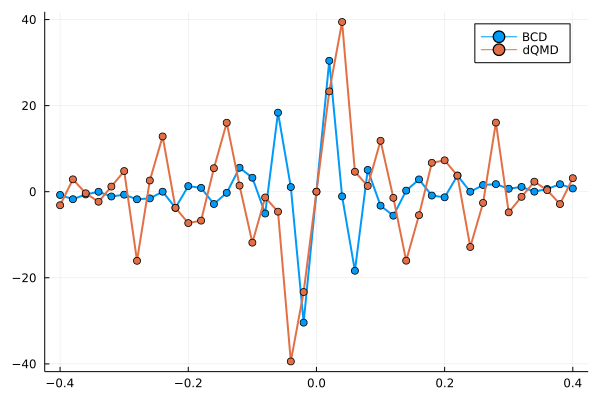

In [51]:
plot(mu0, BCD_XXX4_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX4_mu, label="dQMD", width=2.0, marker=:circle)

In [48]:
total_XXX5_mu = zeros(Float64,length(mu0))
Drude_XXX5_mu = zeros(Float64,length(mu0))
BCD_XXX5_mu = zeros(Float64,length(mu0))
sQMD_XXX5_mu = zeros(Float64,length(mu0))
dQMD_XXX5_mu = zeros(Float64,length(mu0))
Inter_XXX5_mu = zeros(Float64,length(mu0))
dInter_XXX5_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.012, 0.005, 1.0, 250, 0.5, 1000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI2(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XXX5_mu[j] += Drude
        BCD_XXX5_mu[j] += BCD
        sQMD_XXX5_mu[j] += sQMD
        dQMD_XXX5_mu[j] += dQMD
        Inter_XXX5_mu[j] += Inter
        dInter_XXX5_mu[j] += dInter
    end
    total_XXX5_mu[j] = Drude_XXX5_mu[j] + BCD_XXX5_mu[j] + sQMD_XXX5_mu[j] + dQMD_XXX5_mu[j] + Inter_XXX5_mu[j] + dInter_XXX5_mu[j]
end

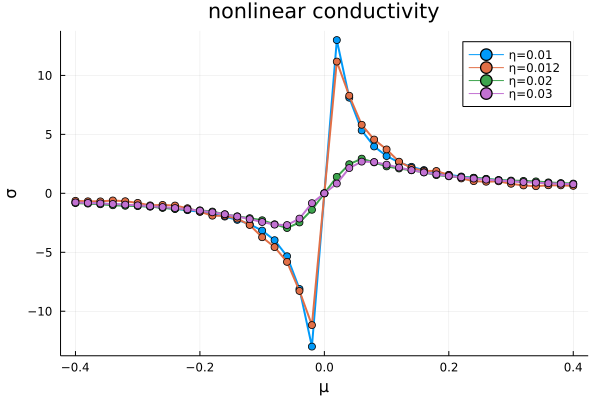

In [50]:
#plot(mu0, Drude_XXX_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot(mu0, dQMD_XXX3_mu+BCD_XXX3_mu, label="η=0.01",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
#plot(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
#plot!(mu0, dQMD_XXX2_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX5_mu+BCD_XXX5_mu, label="η=0.012", width=2.0, marker=:circle)
#plot!(mu0, dQMD_XXX4_mu+BCD_XXX4_mu, label="η=0.015", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX_mu+BCD_XXX_mu, label="η=0.02", width=2.0, marker=:circle)
plot!(mu0, dQMD_XXX2_mu+BCD_XXX2_mu, label="η=0.03", width=2.0, marker=:circle)
#plot!(mu0, Inter_XXX_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter_XXX_mu, label="dInter", width=2.0, marker=:circle)
#plot!(mu0, total_XXX_mu, label="total", width=2.0, marker=:circle)

In [26]:
#ZXY_mu = zeros(Float64,length(mu0))
mu0 = [-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.04, -0.03, -0.02, -0.015, -0.01, -0.005, 0]
eta0 = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
TotalT_XXX_mu = zeros(Float64,length(eta0),length(mu0))
DrudeT_XXX_mu = zeros(Float64,length(eta0),length(mu0))
BCDT_XXX_mu = zeros(Float64,length(eta0),length(mu0))
sQMDT_XXX_mu = zeros(Float64,length(eta0),length(mu0))
dQMDT_XXX_mu = zeros(Float64,length(eta0),length(mu0))
InterT_XXX_mu = zeros(Float64,length(eta0),length(mu0))
dInterT_XXX_mu = zeros(Float64,length(eta0),length(mu0))

for i in 1:length(eta0)
    for j in 1:length(mu0)
        #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
        p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], eta0[i], 0.01, 1.0, 250, 0.5, 1000)

        k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
        for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
            Drude::Float64 = 0.0
            BCD::Float64 = 0.0
            sQMD::Float64 = 0.0
            dQMD::Float64 = 0.0
            Inter::Float64 = 0.0
            dInter::Float64 = 0.0
            Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
                k = (k2[i][1], k2[i][2], kz)
                Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
                Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI(p,Hamk)
                [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
            end
            DrudeT_XXX_mu[i,j] += Drude
            BCDT_XXX_mu[i,j] += BCD
            sQMDT_XXX_mu[i,j] += sQMD
            dQMDT_XXX_mu[i,j] += dQMD
            InterT_XXX_mu[i,j] += Inter
            dInterT_XXX_mu[i,j] += dInter
        end
        TotalT_XXX_mu[i,j] = DrudeT_XXX_mu[i,j]+BCDT_XXX_mu[i,j]+sQMDT_XXX_mu[i,j]+dQMDT_XXX_mu[i,j] + InterT_XXX_mu[i,j] + dInterT_XXX_mu[i,j]
    end
end

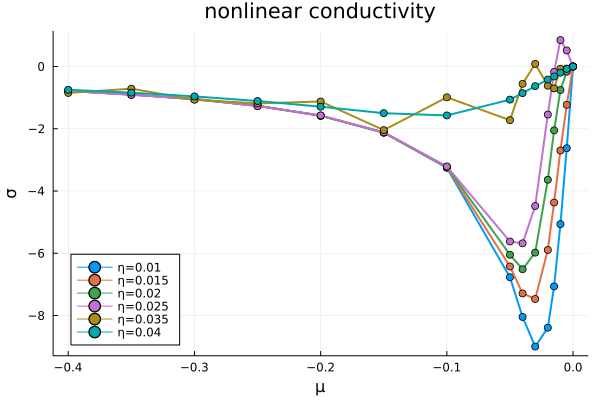

In [34]:
plot(mu0, dQMDT_XXX_mu[1,:]+BCDT_XXX_mu[1,:], label="η=0.01",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle, legend = :bottomleft)
#plot(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
#plot!(mu0, dQMD_XXX2_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, dQMDT_XXX_mu[2,:]+BCDT_XXX_mu[2,:], label="η=0.015", width=2.0, marker=:circle)
plot!(mu0, dQMDT_XXX_mu[3,:]+BCDT_XXX_mu[3,:], label="η=0.02", width=2.0, marker=:circle)
plot!(mu0, dQMDT_XXX_mu[4,:]+BCDT_XXX_mu[4,:], label="η=0.025", width=2.0, marker=:circle)
#plot!(mu0, dQMDT_XXX_mu[5,:]+BCDT_XXX_mu[5,:], label="η=0.03", width=2.0, marker=:circle)
plot!(mu0, dQMDT_XXX_mu[6,:]+BCDT_XXX_mu[6,:], label="η=0.035", width=2.0, marker=:circle)
plot!(mu0, dQMDT_XXX_mu[7,:]+BCDT_XXX_mu[7,:], label="η=0.04", width=2.0, marker=:circle)



Type2

In [20]:
#ZXY_mu = zeros(Float64,length(mu0))
mu0 = [-0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.04, -0.03, -0.02, -0.015, -0.01, -0.005, 0]
eta0 = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
Total2_XXX_mu = zeros(Float64,length(eta0),length(mu0))
Drude2_XXX_mu = zeros(Float64,length(eta0),length(mu0))
BCD2_XXX_mu = zeros(Float64,length(eta0),length(mu0))
sQMD2_XXX_mu = zeros(Float64,length(eta0),length(mu0))
dQMD2_XXX_mu = zeros(Float64,length(eta0),length(mu0))
Inter2_XXX_mu = zeros(Float64,length(eta0),length(mu0))
dInter2_XXX_mu = zeros(Float64,length(eta0),length(mu0))

for i in 1:length(eta0)
    for j in 1:length(mu0)
        #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
        p = Parm(0.5, 0.3, 0.0, 0.0, 0.0, mu0[j], eta0[i], 0.01, 1.0, 250, 0.5, 1000)

        k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
        for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
            Drude::Float64 = 0.0
            BCD::Float64 = 0.0
            sQMD::Float64 = 0.0
            dQMD::Float64 = 0.0
            Inter::Float64 = 0.0
            dInter::Float64 = 0.0
            Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
                k = (k2[i][1], k2[i][2], kz)
                Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
                Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI(p,Hamk)
                [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
            end
            Drude2_XXX_mu[i,j] += Drude
            BCD2_XXX_mu[i,j] += BCD
            sQMD2_XXX_mu[i,j] += sQMD
            dQMD2_XXX_mu[i,j] += dQMD
            Inter2_XXX_mu[i,j] += Inter
            dInter2_XXX_mu[i,j] += dInter
        end
        Total2_XXX_mu[i,j] = Drude2_XXX_mu[i,j]+BCD2_XXX_mu[i,j]+sQMD2_XXX_mu[i,j]+dQMD2_XXX_mu[i,j] + Inter2_XXX_mu[i,j] + dInter2_XXX_mu[i,j]
    end
end

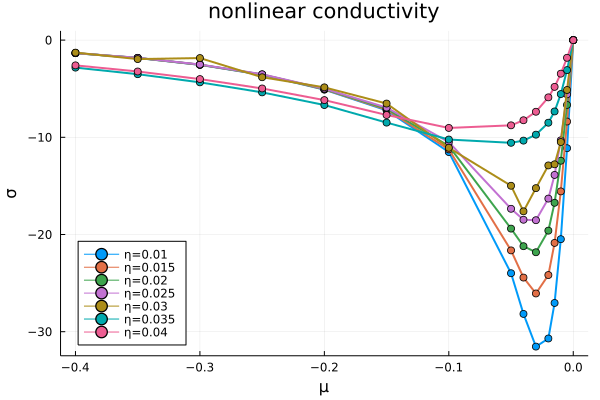

In [33]:
plot(mu0, dQMD2_XXX_mu[1,:]+BCD2_XXX_mu[1,:], label="η=0.01",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle, legend = :bottomleft)
#plot(mu0, BCD_XXX_mu, label="BCD", width=2.0, marker=:circle)
#plot!(mu0, sQMD_XXX_mu, label="sQMD", width=2.0, marker=:circle)
#plot!(mu0, dQMD_XXX2_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XXX_mu[2,:]+BCD2_XXX_mu[2,:], label="η=0.015", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XXX_mu[3,:]+BCD2_XXX_mu[3,:], label="η=0.02", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XXX_mu[4,:]+BCD2_XXX_mu[4,:], label="η=0.025", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XXX_mu[5,:]+BCD2_XXX_mu[5,:], label="η=0.03", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XXX_mu[6,:]+BCD2_XXX_mu[6,:], label="η=0.035", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XXX_mu[7,:]+BCD2_XXX_mu[7,:], label="η=0.04", width=2.0, marker=:circle)
#plot!(mu0, Total2_XXX_mu[1,:], label="η=0.01", width=2.0, marker=:circle)

In [ ]:
total_XYZ_mu = zeros(Float64,length(mu0))
Drude_XYZ_mu = zeros(Float64,length(mu0))
BCD_XYZ_mu = zeros(Float64,length(mu0))
sQMD_XYZ_mu = zeros(Float64,length(mu0))
dQMD_XYZ_mu = zeros(Float64,length(mu0))
Inter_XYZ_mu = zeros(Float64,length(mu0))
dInter_XYZ_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.005, 1.0, 250, 0.5, 1000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XXX_BI2(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XXX_mu[j] += Drude
        BCD_XXX_mu[j] += BCD
        sQMD_XXX_mu[j] += sQMD
        dQMD_XXX_mu[j] += dQMD
        Inter_XXX_mu[j] += Inter
        dInter_XXX_mu[j] += dInter
    end
    total_XXX_mu[j] = Drude_XXX_mu[j] + BCD_XXX_mu[j] + sQMD_XXX_mu[j] + dQMD_XXX_mu[j] + Inter_XXX_mu[j] + dInter_XXX_mu[j]
end

In [22]:
total_XYZ_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    total_XYZ_mu[j] = Drude_XYZ_mu[j] + BCD_XYZ_mu[j] + sQMD_XYZ_mu[j] + dQMD_XYZ_mu[j] + Inter_XYZ_mu[j] + dInter_XYZ_mu[j]
end

In [36]:
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成
save_data4 = DataFrame(mu=mu0,total=total_XYZ_mu,BCD=BCD_XYZ_mu, sQMD=sQMD_XYZ_mu, dQMD=dQMD_XYZ_mu, Inter=Inter_XYZ_mu, dInter=dInter_XYZ_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./mu_dep_NLH_DC_type1_XYZ_T0005.csv", save_data4)

"./mu_dep_NLH_DC_type1_XYZ_T0005.csv"

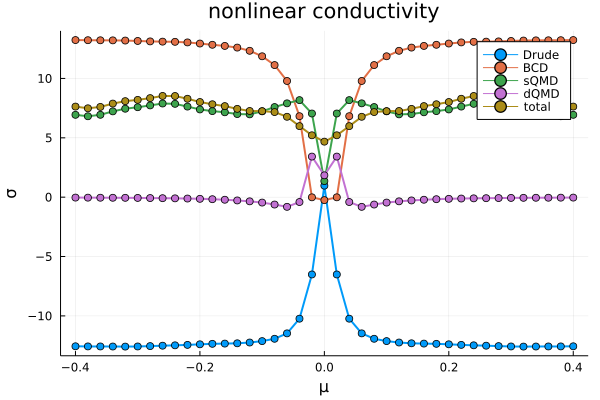

In [23]:
#using Plots
plot(mu0, Drude_XYZ_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BCD_XYZ_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMD_XYZ_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XYZ_mu, label="dQMD", width=2.0, marker=:circle)
#plot!(mu0, Inter_XYZ_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter_XYZ_mu, label="dInter", width=2.0, marker=:circle)
plot!(mu0, total_XYZ_mu, label="total", width=2.0, marker=:circle)

In [24]:
#ZXY_mu = zeros(Float64,length(mu0))
total2_XYZ_mu = zeros(Float64,length(mu0))
Drude2_XYZ_mu = zeros(Float64,length(mu0))
BCD2_XYZ_mu = zeros(Float64,length(mu0))
sQMD2_XYZ_mu = zeros(Float64,length(mu0))
dQMD2_XYZ_mu = zeros(Float64,length(mu0))
Inter2_XYZ_mu = zeros(Float64,length(mu0))
dInter2_XYZ_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.5, 0.3, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.005, 1.0, 400, 0.5, 2000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XYZ_BI(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude2_XYZ_mu[j] += Drude
        BCD2_XYZ_mu[j] += BCD
        sQMD2_XYZ_mu[j] += sQMD
        dQMD2_XYZ_mu[j] += dQMD
        Inter2_XYZ_mu[j] += Inter
        dInter2_XYZ_mu[j] += dInter
    end
    total2_XYZ_mu[j] = Drude2_XYZ_mu[j] + BCD2_XYZ_mu[j] + sQMD2_XYZ_mu[j] + dQMD2_XYZ_mu[j] + Inter2_XYZ_mu[j] + dInter2_XYZ_mu[j] 
end

In [35]:
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成
save_data3 = DataFrame(mu=mu0,total=total2_XYZ_mu,BCD=BCD2_XYZ_mu, sQMD=sQMD2_XYZ_mu, dQMD=dQMD2_XYZ_mu, Inter=Inter2_XYZ_mu, dInter=dInter2_XYZ_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./mu_dep_NLH_DC_type2_XYZ_T0005.csv", save_data3)

"./mu_dep_NLH_DC_type2_XYZ_T0005.csv"

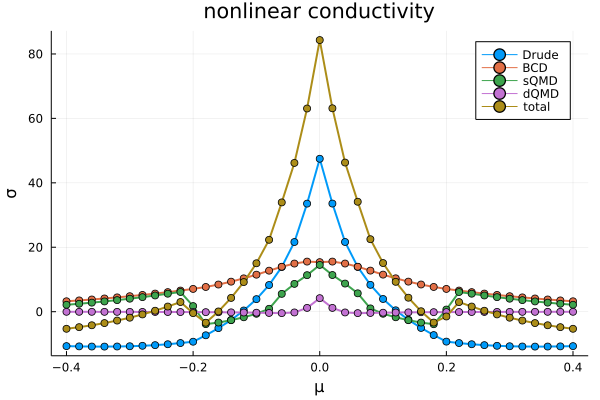

In [25]:
plot(mu0, Drude2_XYZ_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BCD2_XYZ_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMD2_XYZ_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XYZ_mu, label="dQMD", width=2.0, marker=:circle)
#plot!(mu0, Inter_XYZ_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter_XYZ_mu, label="dInter", width=2.0, marker=:circle)
plot!(mu0, total2_XYZ_mu, label="total", width=2.0, marker=:circle)

有限温度も見てみよう

In [12]:
#ZXY_mu = zeros(Float64,length(mu0))
#mu0 = collect(-0.4:0.02:0.4)

Drude_XYZT_mu = zeros(Float64,length(mu0))
BCD_XYZT_mu = zeros(Float64,length(mu0))
sQMD_XYZT_mu = zeros(Float64,length(mu0))
dQMD_XYZT_mu = zeros(Float64,length(mu0))
Inter_XYZT_mu = zeros(Float64,length(mu0))
dInter_XYZT_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.3, 1.0, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.03, 1.0, 400, 0.5, 2000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XYZ_BI(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude_XYZT_mu[j] += Drude
        BCD_XYZT_mu[j] += BCD
        sQMD_XYZT_mu[j] += sQMD
        dQMD_XYZT_mu[j] += dQMD
        Inter_XYZT_mu[j] += Inter
        dInter_XYZT_mu[j] += dInter
    end
    
end

In [31]:
total_XYZT_mu = zeros(Float64,length(mu0))
for j in 1:length(mu0)
    total_XYZT_mu[j] = Drude_XYZT_mu[j] + BCD_XYZT_mu[j] + sQMD_XYZT_mu[j] + dQMD_XYZT_mu[j] + Inter_XYZT_mu[j] + dInter_XYZT_mu[j]
end

In [34]:
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成
save_data2 = DataFrame(mu=mu0,total=total_XYZT_mu,BCD=BCD_XYZT_mu, sQMD=sQMD_XYZT_mu, dQMD=dQMD_XYZT_mu, Inter=Inter_XYZT_mu, dInter=dInter_XYZT_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./mu_dep_NLH_DC_type1_XYZ_T003.csv", save_data2)

"./mu_dep_NLH_DC_type1_XYZ_T003.csv"

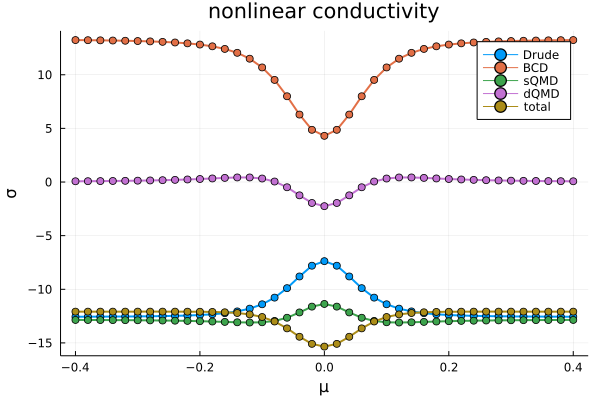

In [33]:
plot(mu0, Drude_XYZT_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BCD_XYZT_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMD_XYZT_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD_XYZT_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, total_XYZT_mu, label="total", width=2.0, marker=:circle)
#plot!(mu0, Inter_XYZT_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter_XYZT_mu, label="dInter", width=2.0, marker=:circle)

In [26]:
total2_XYZT_mu = zeros(Float64,length(mu0))
Drude2_XYZT_mu = zeros(Float64,length(mu0))
BCD2_XYZT_mu = zeros(Float64,length(mu0))
sQMD2_XYZT_mu = zeros(Float64,length(mu0))
dQMD2_XYZT_mu = zeros(Float64,length(mu0))
Inter2_XYZT_mu = zeros(Float64,length(mu0))
dInter2_XYZT_mu = zeros(Float64,length(mu0))

for j in 1:length(mu0)
    #Parm: m, lamda, hx, hy, hz, mu, eta, T, K_MAX, K_SIZE, W_MAX, W_SIZE
    p = Parm(0.5, 0.3, 0.0, 0.0, 0.0, mu0[j], 0.02, 0.03, 1.0, 400, 0.5, 2000)

    k2 = collect(Iterators.product((-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1], (-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]))
    for kz in collect(-p.K_MAX:2*p.K_MAX/p.K_SIZE:p.K_MAX)[1:end-1]
        Drude::Float64 = 0.0
        BCD::Float64 = 0.0
        sQMD::Float64 = 0.0
        dQMD::Float64 = 0.0
        Inter::Float64 = 0.0
        dInter::Float64 = 0.0
        Drude, BCD, sQMD, dQMD, Inter, dInter = @distributed (+) for i in 1:length(k2)
            k = (k2[i][1], k2[i][2], kz)
            Hamk = Hamiltonian_3D(HandV_weyl(k,p)...)
            Drude0, BCD0, sQMD0, dQMD0, Inter0, dInter0 = Green_XYZ_BI(p,Hamk)
            [Drude0/(p.K_SIZE^3), BCD0/(p.K_SIZE^3), sQMD0/(p.K_SIZE^3), dQMD0/(p.K_SIZE^3), Inter0/(p.K_SIZE^3), dInter0/(p.K_SIZE^3)]
        end
        Drude2_XYZT_mu[j] += Drude
        BCD2_XYZT_mu[j] += BCD
        sQMD2_XYZT_mu[j] += sQMD
        dQMD2_XYZT_mu[j] += dQMD
        Inter2_XYZT_mu[j] += Inter
        dInter2_XYZT_mu[j] += dInter
    end
    total2_XYZT_mu[j] = Drude2_XYZT_mu[j] + BCD2_XYZT_mu[j] + sQMD2_XYZT_mu[j] + dQMD2_XYZT_mu[j] + Inter2_XYZT_mu[j] + dInter2_XYZT_mu[j] 
end

In [29]:
# headerの名前を(Q,E1,E2)にして、CSVファイル形式を作成
save_data1 = DataFrame(mu=mu0,total=total2_XYZT_mu,BCD=BCD2_XYZT_mu, sQMD=sQMD2_XYZT_mu, dQMD=dQMD2_XYZT_mu, Inter=Inter2_XYZT_mu, dInter=dInter2_XYZT_mu)
#「./」で現在の(tutorial.ipynbがある)ディレクトリにファイルを作成の意味、指定すれば別のディレクトリにファイルを作ることも出来る。
CSV.write("./mu_dep_NLH_DC_XYZ_T003.csv", save_data1)

"./mu_dep_NLH_DC_XYZ_T003.csv"

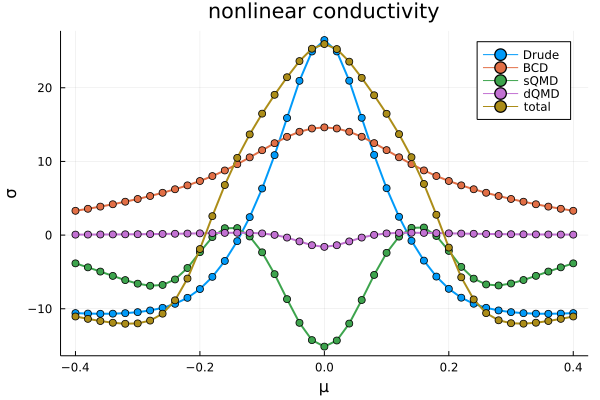

In [28]:
plot(mu0, Drude2_XYZT_mu, label="Drude",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(mu0, BCD2_XYZT_mu, label="BCD", width=2.0, marker=:circle)
plot!(mu0, sQMD2_XYZT_mu, label="sQMD", width=2.0, marker=:circle)
plot!(mu0, dQMD2_XYZT_mu, label="dQMD", width=2.0, marker=:circle)
plot!(mu0, total2_XYZT_mu, label="total", width=2.0, marker=:circle)
#plot!(mu0, Inter2_XYZT_mu, label="Inter", width=2.0, marker=:circle)
#plot!(mu0, dInter2_XYZT_mu, label="dInter", width=2.0, marker=:circle)

In [16]:
using DataFrames
using CSV

In [21]:
read_data = CSV.read("//wsl/home/ymichishita/Data/Tweyl_Green_NLH_2022_0105/mu_dep_NLH.csv", DataFrame)

plot(read_data[:,1], read_data[:,2], label="ZXY",xlabel="μ",ylabel="σ",title="nonlinear conductivity", width=2.0, marker=:circle)
plot!(read_data[:,1], read_data[:,3],label="XYZ", width=2.0, marker=:circle)

LoadError: IOError: stat("//wsl/home/ymichishita/Data/Tweyl_Green_NLH_2022_0105/mu_dep_NLH.csv"): unknown error (UNKNOWN)

In [ ]:
#=
@everywhere function HandV_topo(k::NTuple{2, Float64},p::Parm)

    eps::Float64 = -p.t* (p.Pr*cos(k*a1) + cos(k*a2) + cos(k*a1+k*a2)) + p.mu
    g_x::Float64 = p.lamda_u * (sin(k*a1+k*a2) + sin(k*a2)) / 2.0 + p.hx
    g_y::Float64 = -p.lamda_u * (sin(k*a1) + (sin(k*a1+k*a2) - sin(k*a2))/2.0)/sqrt(3.0) + p.hy
    g_z::Float64 = 2.0 * p.lamda_d * (sin(k*a1) + sin(k*a2) - sin(k*a1+k*a2))/(3.0*sqrt(3.0)) + p.hz
    gg = [eps, g_x, g_y, g_z]
    H::Array{ComplexF64,2} =  sigma*gg

    eps_vx::Float64 = -p.t* (-p.Pr*sin(k*a1) + 0.5*sin(k*a2) - 0.5*sin(k*a1+k*a2))
    gx_vx::Float64 = p.lamda_u * (0.5*cos(k*a1+k*a2) - 0.5*cos(k*a2)) / 2.0
    gy_vx::Float64 = -p.lamda_u * (cos(k*a1) + (0.5*cos(k*a1+k*a2) + 0.5*cos(k*a2))/2.0)/sqrt(3.0)
    gz_vx::Float64 = 2.0 * p.lamda_d * (cos(k*a1) - 0.5*cos(k*a2) - 0.5*cos(k*a1+k*a2))/(3.0*sqrt(3.0))
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vx::Array{ComplexF64,2} = sigma*gg_x


    eps_vy::Float64 = -p.t* (0.5*sin(k*a2) - 0.5*sin(k*a1+k*a2))
    gx_vy::Float64 = p.lamda_u * (0.5*cos(k*a1+k*a2) - 0.5*cos(k*a2)) / 2.0
    gy_vy::Float64 = -p.lamda_u * (cos(k*a1) + (0.5*cos(k*a1+k*a2) + 0.5*cos(k*a2))/2.0)/sqrt(3.0)
    gz_vy::Float64 = 2.0 * p.lamda_d * (cos(k*a1) - 0.5*cos(k*a2) - 0.5*cos(k*a1+k*a2))/(3.0*sqrt(3.0))
    gg_x = [eps_vx, gx_vx, gy_vx, gz_vx]
    Vy::Array{ComplexF64,2} = [p.t*(sin(k[2])) p.lamda*(-im*cos(k[2]))
    p.lamda*(im*cos(k[2])) -p.t*(sin(k[2]))]

    Vxx::Array{ComplexF64,2} = [p.t*(cos(k[1])) p.lamda*(sin(k[1]))
    p.lamda*(sin(k[1])) -p.t*(cos(k[1]))]

    Vyx::Array{ComplexF64,2} = [0.0 0.0
    0.0 0.0]

    E::Array{ComplexF64,1} = zeros(2)

    return H, Vx, Vy, Vxx, Vyx, E 
end

@everywhere function Gk(w::Float64, p::Parm, Ham::Hamiltonian)
    #Green関数のinverse
    GR0::Array{ComplexF64,2} = -Ham.Hk + Matrix{Complex{Float64}}(w*I,2,2) + p.eta*Matrix{Complex{Float64}}(1.0im*I,2,2)

    GR::Array{ComplexF64,2} = inv(GR0)
    GA::Array{ComplexF64,2} = GR'
    GRmA::Array{ComplexF64,2} = GR - GA
    dGR::Array{ComplexF64,2} = - GR * GR
    dGA::Array{ComplexF64,2} = - GA * GA
    GRp = zeros(ComplexF64,2,2)
    GAm = zeros(ComplexF64,2,2)
    return GR, GA, dGR, dGA, GRmA, GRp, GAm
end
=#